# MarketCap Model
Refer to our analysis paper to see the equations and how we derived them

In [1]:
from dataclasses import dataclass
import numpy as np

@dataclass
class Model:
    # exponential rate parameters
    cash_growth_rate: float = 0.3 # g
    discount_rate: float = 0.4 # r
    dilution_rate: float = 0.1 # omega
    equilibrium_interest_rate: float = 0.05 # i

    # other parameters
    proportion_interest_on_cash: float = 0.5 # beta
    dilution_lower_bound: float = 0.5 # alpha
    initial_cash_supply: float = 1e7 # S0
    cash_velocity: float = 20 # v
    fee_percentage: float = 0.2 / 100 # f
    
    def run(self, t):
        return dict(
            marketcap_w_interest=self._marketcap_w_interest(t),
            marketcap_wo_interest=self._marketcap_wo_interest(t),
            pv_demand_from_cash=self._pv_demand_from_cash(t),
            pv_demand_from_fees=self._pv_demand_from_fees(t),
            pv_demand_from_interest_fees=self._pv_demand_from_interest_fees(t),
            pv_demand_from_interest_mint=self._pv_demand_from_interest_mint(t),
        )
    
    def _marketcap_w_interest(self, t):
        return self._pv_demand_from_cash(t) + self._pv_demand_from_fees(t) + self._pv_demand_from_interest_fees(t) + self._pv_demand_from_interest_mint(t)   
    
    def _marketcap_wo_interest(self, t):
        return self._pv_demand_from_cash(t) + self._pv_demand_from_fees(t)   
    
    def _pv_demand_from_cash(self, t):
        return (
            self.cash_growth_rate * 
            self.initial_cash_supply *
            (
                (1 - self.dilution_lower_bound) * np.exp((self.cash_growth_rate - self.dilution_rate) * t) / (self.discount_rate + self.dilution_rate - self.cash_growth_rate)
                +
                self.dilution_lower_bound * np.exp(self.cash_growth_rate * t) / (self.discount_rate - self.cash_growth_rate)
            )
        )
    
    def _pv_demand_from_fees(self, t):
        return self._pv_demand_from_cash(t) * self.cash_velocity * self.fee_percentage / self.cash_growth_rate 
    
    def _pv_demand_from_interest_fees(self, t):
        return self._pv_demand_from_fees(t) * self.proportion_interest_on_cash * self.cash_growth_rate / self.equilibrium_interest_rate
    
    def _pv_demand_from_interest_mint(self, t):
        return (np.reciprocal(
            1 - (
                (self.proportion_interest_on_cash * (1 - self.dilution_lower_bound) * self.dilution_rate) / self.equilibrium_interest_rate *
                (
                    (1 - self.dilution_lower_bound) * np.exp(-2 * self.dilution_rate * t) / (self.discount_rate + 2 * self.dilution_rate)
                    +
                    self.dilution_lower_bound * np.exp(-self.dilution_rate * t) / (self.discount_rate + self.dilution_rate)
                )
            )
        ) - 1) * (self._pv_demand_from_cash(t) + self._pv_demand_from_fees(t) + self._pv_demand_from_interest_fees(t))
    

# Running the Model

In [2]:
t = np.arange(0, 10.1, 0.1) # 0 to 10 years

results = Model(
        cash_growth_rate=0.35,
        discount_rate=0.6,
        dilution_rate=0.08,
        equilibrium_interest_rate=0.05,

        # other parameters
        proportion_interest_on_cash=0.5,
        dilution_lower_bound=0.5
).run(t)

results_rounded = {
    k: np.round(v / 1e6, 1) * 1e6
    for k, v in results.items()
}

# Plotting Results

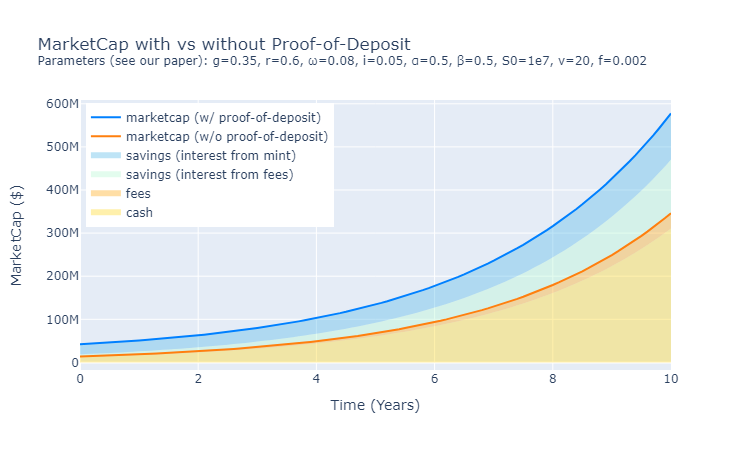

In [22]:
import plotly.graph_objects as go

fig = go.Figure()

def stack_plot(name, y, color):    
    fig.add_trace(
        go.Scatter(
            x=t, 
            y=y,
            stackgroup='one',
            mode= 'none',
            name=name,
            hoverinfo='y',
            fillcolor=color
        )
    )

def line_plot(name, y, color):
    fig.add_trace(
        go.Scatter(
            x=t, 
            y=y,
            mode='lines',
            name=name,
            hoverinfo='y',
            line=dict(
                color=color
            )
        )
    )

stack_plot("cash", results_rounded["pv_demand_from_cash"], 'rgba(255, 217, 47, 0.4)')
stack_plot("fees", results_rounded["pv_demand_from_fees"], 'rgba(255, 172, 30, 0.4)')
stack_plot("savings (interest from fees)", results_rounded["pv_demand_from_interest_fees"], 'rgba(184, 247, 212, 0.4)')
stack_plot("savings (interest from mint)", results_rounded["pv_demand_from_interest_mint"], 'rgba(92, 188, 233, 0.4)')
line_plot("marketcap (w/o proof-of-deposit)", results_rounded["marketcap_wo_interest"], 'rgb(255, 127, 14)')
line_plot("marketcap (w/ proof-of-deposit)", results_rounded["marketcap_w_interest"], 'rgb(0, 128, 255)')
    
fig.update_layout(
    title="MarketCap with vs without Proof-of-Deposit"
    '<br><sup>Parameters (<a href="http://files.cambridgecryptographic.com/whitepapers/marketcap_model_v0.1.pdf">see our paper</a>): g=0.35, r=0.6, ω=0.08, i=0.05, α=0.5, β=0.5, S0=1e7, v=20, f=0.002</sup>',
    xaxis_title="Time (Years)",
    yaxis_title="MarketCap ($)",
    hovermode="x unified",
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    )
)
fig.show()

In [23]:
import chart_studio
username = 'ying_chan' # your username
api_key = 'aJKt1B3KhLj6zLUFLbPa' # your api key - go to profile > settings > regenerate key
chart_studio.tools.set_credentials_file(username=username, api_key=api_key)
chart_studio.plotly.plot(fig, filename = 'marketcap_model', auto_open=True)

'https://plotly.com/~ying_chan/1/'